In [83]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Preparation and Cleaning

In [2]:
# generate music lyrics df 
#with codecs.open("music_lyrics.csv", "r", encoding='utf-8', errors='ignore') as csv_file:
    #lyrics_df = pd.read_csv(csv_file)

lyrics_df = pd.read_csv('music_lyrics.csv', encoding='latin-1')

# replace \n separator from lyrics with empty space 
lyrics_df = lyrics_df.replace({'\n': ' '}, regex=True)
# create lyric word count column 
lyrics_df['lyric_count'] = lyrics_df['lyrics'].str.split().str.len()

In [3]:
# remove entries with lyric word counts equal to 1 
clean_df = lyrics_df[lyrics_df['lyric_count'] != 1]
# filter entries with lyrics word counts equal to or greater than 100
clean_df = clean_df[clean_df['lyric_count'] >= 100]
# filter entries with lyrics word counts equal to or less than 1000
clean_df = clean_df[clean_df['lyric_count'] <= 1000]
# remove entries with erroenous year data starting at 1970 onwards 
clean_df = clean_df[clean_df.year >= 1970]
# remove any rows with missing values 
clean_df = clean_df.dropna(how='any') 
# scrub the df for random lyric duplicates
clean_df = clean_df.drop_duplicates('lyrics')
# filter only artists with atleast 10 songs
clean_df = clean_df[clean_df.groupby('artist')['song'].transform('nunique') >= 10]
# filter songs with 5 or more observations 
clean_df = clean_df.groupby('song').filter(lambda x: len(x) >= 3)

In [4]:
# remove common directional words in lyrics as well as americon idol as this does not tether to a specific artist 
clean_df = clean_df[clean_df.genre != 'Other']
clean_df = clean_df[clean_df.genre != 'Not Available']
clean_df = clean_df[clean_df.lyrics != 'INSTRUMENTAL']
clean_df = clean_df[clean_df.lyrics != 'instrumental']
clean_df = clean_df[clean_df.lyrics != 'Instrumental']
clean_df = clean_df[clean_df.lyrics != '[Instrumental]']
clean_df = clean_df[clean_df.lyrics != '[instrumental]']
clean_df = clean_df[clean_df.lyrics != '(Instrumental)']
clean_df = clean_df[clean_df.lyrics != '(instrumental)']
clean_df = clean_df[clean_df.lyrics != 'Instru']
clean_df = clean_df[clean_df.artist != 'american-idol']

### Exploratory Analysis

In [5]:
# generate new exploratory df using random samples of 75% capacity of original df 
explore_df = clean_df.sample(frac=0.75)
# set year as index 
explore_df.index = explore_df.year
# sort year index 
explore_df.sort_index(inplace=True)

In [6]:
# define function for text normalization
def text_to_norm(x):
    x = x.lower()
    x = re.sub('\s\W',' ', x)
    x = re.sub('\W\s',' ', x)
    x = re.sub('\s+',' ', x)
    x = re.sub("'", "", x)
    return x

In [7]:
# custom stop words 
custom_stop = ["'s", "n't", "'m", "'re", "'ll","'ve","...", "ä±", "''", '``', '--', "'d", 'el', 'la']
# Remove stop words
stop_words = nltk.corpus.stopwords.words('english') + custom_stop

In [8]:
# normalize text 
explore_df['text'] = [text_to_norm(x) for x in explore_df['lyrics']]
# remove stop words from text
explore_df['text'] = [i for i in explore_df['text'] if i not in stop_words]
# convert genre values to lowercase for cleanliness  
explore_df['genre'] = [x.lower() for x in explore_df['genre']]

/Users/nicholastaub/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  after removing the cwd from sys.path.


In [9]:
# remove duplicative index, year and lyrics columns
explore_df = explore_df.drop(['index','year', 'lyrics'], axis=1)

In [10]:
# check exploratory df 
#explore_df.head()

In [11]:
# value count of genres 
explore_df.genre.value_counts()

rock          15732
pop            7021
hip-hop        3265
country        2164
metal          1940
jazz           1255
electronic      860
r&b             540
indie           351
folk            183
Name: genre, dtype: int64

In [12]:
# store unique counts of artists and songs 
unique_artists = len(explore_df.artist.unique())
unique_tracks = len(explore_df.song.unique())

In [13]:
# print count of unique artists 
unique_artists

3789

In [14]:
# print count of unique tracks
unique_tracks

8374

#### The below violin plot illutrates that most lyrics consist of 150-200 words total

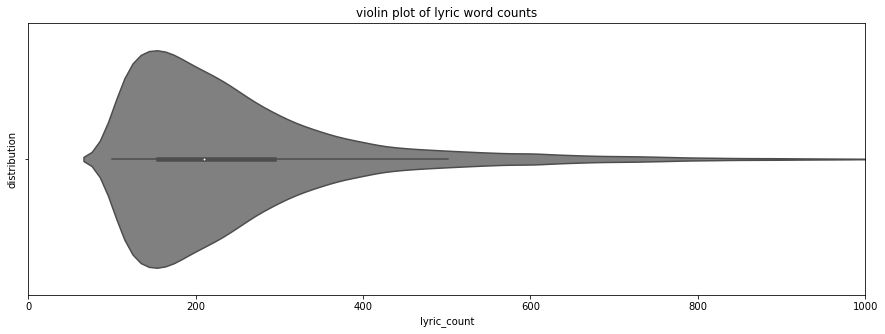

In [15]:
plt.figure(figsize=(15,5))
sns.violinplot(x=explore_df["lyric_count"], color='grey')
plt.title('violin plot of lyric word counts')
plt.ylabel('distribution')
plt.xlim(0, 1000)
plt.show()

#### The below chart indicates the relative appeal of rock music

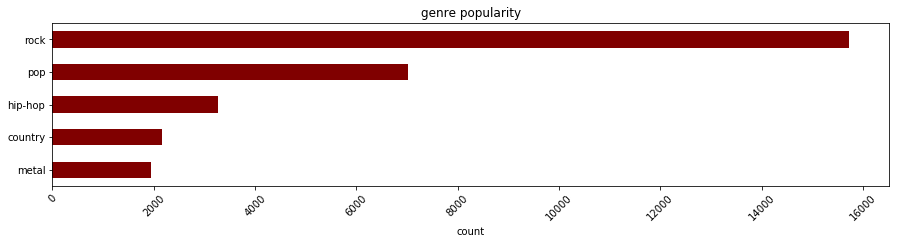

In [16]:
plt.figure(figsize=(15,3))
plt.title('genre popularity')
plt.xlabel('count')
plt.xticks(rotation=45)
top_genres = explore_df['genre'].value_counts().nlargest(5).sort_values().plot.barh(color='maroon')
plt.show()

In [17]:
# define function to check top ten artists by genre 
def genre_count(genre):
    genre = str(genre)
    top_genre = explore_df[explore_df['genre'] == genre]
    top_bands = top_genre.groupby('artist')['song'].count().nlargest(10)
    plt.figure(figsize=(15,3))
    top_bands.plot(kind='bar', color='teal')
    title_form = 'top ten {} artists based on song frequency'.format(genre)
    plt.title(title_form)
    plt.xlabel('artist')
    plt.xticks(rotation=45)
    plt.ylabel('count')
    plt.show()

#### Function output of top ten rock artists

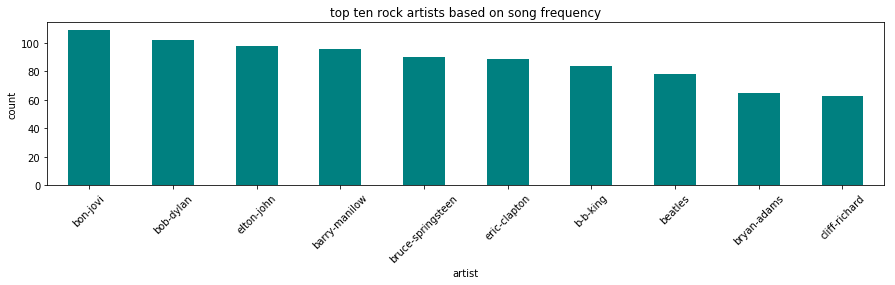

In [18]:
genre_count('rock')

#### Function output of top ten pop artists

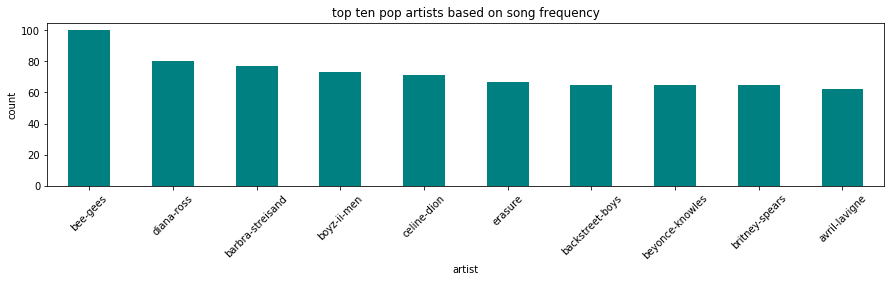

In [19]:
genre_count('pop')

#### Function output of top ten hip-hop artists

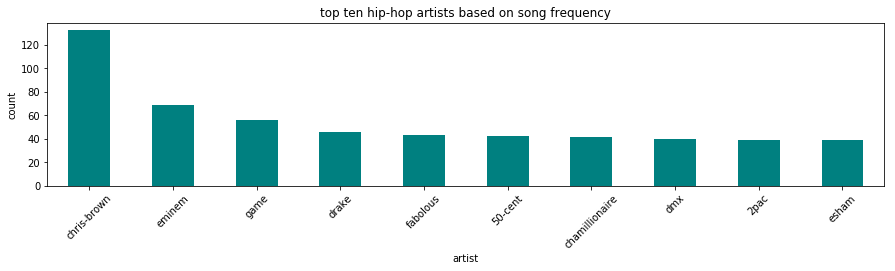

In [20]:
genre_count('hip-hop')

### Mini Batch KMeans

In [21]:
# make separate modeling df for version control 
model_df = explore_df.copy()

In [22]:
# instantiate snowball stemmer and regex tokenizer 
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

# define function using stemmer and tokenizer  
def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [23]:
# fit vectors of unique word counts in text
tfid_vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenize, max_features = 1000)
X = tfid_vectorizer.fit_transform(model_df['text'])

In [24]:
# check stored vocabulary of tfid vectorizer 
tfid_terms = tfid_vectorizer.get_feature_names()

In [25]:
# dimension reduction using truncasted SVD 
svd = TruncatedSVD(n_components=5, random_state = 0)
X_SVD = svd.fit_transform(X)

In [59]:
# fit and train k-mean clustering
kmeans = MiniBatchKMeans(n_clusters=5, random_state=0, batch_size=100, n_init=10).fit(X_SVD)

In [60]:
# verify cluster centers 
kmeans.cluster_centers_

array([[ 0.32025609, -0.02049318, -0.00579387, -0.00831224,  0.10489352],
       [ 0.20190582,  0.00447656, -0.0518265 ,  0.02810877, -0.02761749],
       [ 0.2866741 , -0.13315308,  0.07306   , -0.05336926, -0.062026  ],
       [ 0.30029197,  0.20523924,  0.05655524, -0.10174247, -0.04537494],
       [ 0.26421891,  0.07817988,  0.19609895,  0.25712688, -0.02886244]])

In [61]:
# fit predict clusters using mini batch kmeans model
text_clusters = kmeans.fit_predict(X_SVD)

In [62]:
# display distance of observations by cluster groups
cluster_plot = pd.DataFrame(list(X_SVD), list(text_clusters))
cluster_plot = cluster_plot.reset_index()
cluster_plot.rename(columns = {'index': 'Cluster'}, inplace = True)
cluster_plot['Cluster'] = cluster_plot['Cluster'].astype(int)
cluster_plot.index = cluster_plot.Cluster
clust_plot = cluster_plot.drop(['Cluster'], axis=1)

In [63]:
# check first ten rows 
clust_plot.head(10)

,0,1,2,3,4
Cluster,,,,,
1,0.280038,-0.063461,-0.075645,-0.001212,-0.051847
1,0.176477,-0.018653,-0.147685,0.076959,-0.099194
0,0.261795,0.079558,0.231717,-0.004086,0.096127
0,0.404325,0.129504,0.254591,0.017595,0.224624
1,0.169406,-0.035018,0.108418,0.018194,-0.017551
1,0.185375,0.013349,-0.109116,0.046250,-0.006481
1,0.210315,-0.004986,-0.113101,0.028114,0.007629
1,0.199999,-0.059801,-0.054064,0.022976,-0.015440
0,0.383985,0.115631,-0.051641,-0.045904,0.094137


In [73]:
# group cluster labels by count 
cluster_group = cluster_plot.groupby('Cluster').agg({'Cluster': 'count'})
cluster_group.columns = ['Count']
cluster_group

/Users/nicholastaub/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'Cluster' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,Count
Cluster,
0,6836
1,17275
2,4565
3,3074
4,1561


### NMF & LDA 

In [75]:
# instantiate count vectorizer for probabilistic graphical modeling
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words=stop_words)

In [84]:
# fit raw text data to count vectorizer instance 
tf = count_vectorizer.fit_transform(model_df['text'])

In [85]:
# get feature names from count vectorizer
tf_feature_names = count_vectorizer.get_feature_names()
# encode feature name list with utf-8
tf_feature_names = [item.encode("utf-8") for item in tf_feature_names]

In [99]:
# instantiate and train NMF and LDA models 
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(X)
lda = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [100]:
# define function for printing top ten topic cluster across NMF and LDA models 
def topic_generator(model, feature_names, num_topics):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic %d:" % (topic_idx), " ".join([feature_names[i] for i in topic.argsort()[:-num_topics - 1:-1]])

#### The below results illustrate topic clustering from the NMF and LDA models

In [101]:
# print NMF results
print 'Topic Clusters with Non-Negative Matrix Factorization', '\n'
topic_generator(nmf, tfid_terms, 10)

Topic Clusters with Non-Negative Matrix Factorization 

Topic 0: time never one know way could ive say cant thing
Topic 1: love heart give need true kiss sweet alway feel never
Topic 2: nigga get like got aint fuck shit bitch ya yeah
Topic 3: oh yeah whoa ooh ah boy woah yes lord hey
Topic 4: dont want know need wanna whi say care tell feel
Topic 5: im gonna caus ive feel cant think home know sorri
Topic 6: babi girl yeah come wanna gonna got ooh hey good
Topic 7: let go get take wont away cant back know never
Topic 8: come night away light dream day world eye home heart
Topic 9: ill never youll wait alway give take wont day need


In [102]:
# print LDA results
print 'Topic Clusters with Latent Dirichlet Allocation', '\n'
topic_generator(lda, tf_feature_names, 10)

Topic Clusters with Latent Dirichlet Allocation 

Topic 0: baby dont yeah want wanna girl know got hey like
Topic 1: come back take lets around youre dance world round go
Topic 2: away time life see eyes day never world heart feel
Topic 3: get like got aint cause dont cant gotta keep time
Topic 4: like night na one home well old song sing high
Topic 5: go let dont know wont us run take give please
Topic 6: im nigga ya shit fuck money niggas yo bitch em
Topic 7: oh da save yeah whoa ah yes bad lay dream
Topic 8: love know youre never one dont say heart could cant
Topic 9: im gonna ive ill know time long day going man
